In [1]:
import tseriesRoutines as routines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil
from math import sqrt
import sqlite3
from statsmodels.tsa.stattools import acf, pacf
import statsmodels.tsa.api as smt
import seaborn as sns
import statsmodels.api as sm
import warnings
import itertools

In [2]:
def genData(mongoid, conn, cursor, impute=True, freq='daily', standardize=False):
    '''
    Generate a timeseries dataframe for ARIMA modelling.
    mongoid: str. string of mongodb id.
    conn: sqlite3 connection.
    cursor: sqlite3 cursor.
    impute:
    freq:
    actualrevcount:
    standardize
    Example:
    product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, 
       freq='daily', actualrevcount=20, standardize=True)
    '''
    initial = routines.sqlToDf(conn, cursor)
    allproduct = initial.selectReview3(mongoid, impute=impute)
    product = routines.tsSalesRateSentiment(allproduct, freq=freq, standardize=standardize)
    product = product[['Sales']]
    return product


In [3]:
# Jeffrey Yau
def tsplot(y, title, lags=None, figsize=(12, 8)):
    '''
    Examine the patterns of ACF and PACF, along with the time series
    plot and histogram.
    '''
    fig = plt.figure(figsize=figsize)
    layout = (2, 2)
    ts_ax = plt.subplot2grid(layout, (0, 0))
    hist_ax = plt.subplot2grid(layout, (0, 1))
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    
    y.plot(ax=ts_ax)
    ts_ax.set_title(title, fontsize=14, fontweight='bold')
    y.plot(ax=hist_ax, kind='hist', bins=25)
    hist_ax.set_title('Histogram')
    smt.graphics.plot_acf(y, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax)
    [ax.set_xlim(0) for ax in [acf_ax, pacf_ax]]
    sns.despine()
    plt.tight_layout()
    return ts_ax, acf_ax, pacf_ax

In [4]:
#https://www.digitalocean.com/community/tutorials/a-guide-to-time-series-forecasting-with-arima-in-python-3
def detpq(data, par=range(0,6)):
    '''
    Determine values of p & q that minimize AICc

    par: python range. parameter
    data: numpy ndarray or pandas series.
        y_train['Sales'].values
    sdfa
    '''
    # Define the p and q parameters to take any value between par
    p = d = q = par
    
    # Generate all different combinations of p, d and q triplets
    pdq = list(itertools.product(p, d, q))

    #warnings.filterwarnings("ignore") # specify to ignore warning messages
    AIC_list = pd.DataFrame({}, columns=['param','AIC'])
    for param in pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(data, order=param)
            results = mod.fit()
            #print('ARIMA{} - AIC:{}'.format(param, 
            #    sm.tools.eval_measures.aicc(results.llf, 
            #        results.nobs, results.df_model)))
            temp = pd.DataFrame([[ param, results.aic]],
                                columns=['param', 'AIC'])
            AIC_list = AIC_list.append( temp, ignore_index=True)
            del temp
        except:
            continue
    
    #m = np.amin(AIC_list['AIC'].values) # Find minimum value in AIC
    #l = AIC_list['AIC'].tolist().index(m) # Find index number for lowest AIC
    #Min_AIC_list = AIC_list.iloc[l,:]

    AIC_list = AIC_list.sort_values(by='AIC').reset_index()
    AIC_list.columns = ['index', 'param', 'AIC']
    return AIC_list

In [5]:
# make connection to sqlite db
conn = sqlite3.connect('product.db')
c = conn.cursor()

# enable foreign keys
c.execute("PRAGMA foreign_keys = ON")
conn.commit()

In [6]:
# result reproducibility
np.random.seed(42)

<br>pilihan:
>     2 data di database product.db dgn review > 900:
>         5aa2ad7735d6d34b0032a795
>         5aa39533ae1f941be7165ecd
>     cluster 3
>         5a93e8768cbad97881597597
>         or 
>         5a95d7ae35d6d33d3fea56ff
>     cluster 1
>         5aa2c35e35d6d34b0032a796
>     cluster 2 
>         5a92474635d6d32207bcd343
</br>

## <font color=blue> 1. Mongodb ID: 5aa2ad7735d6d34b0032a795 </font>

In [7]:
prod1 = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, freq='daily', standardize=False)

In [8]:
prod1.shape

(479, 1)

In [9]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod1['Sales'], '5aa2ad7735d6d34b0032a795')
prod1Test.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-1.500036e+01,Test Statistic
1,2.185321e-22,p-value
2,1.000000e+00,#Lags Used
3,4.770000e+02,Number of Observations Used
4,-3.977875e+00,Critical value for 1%
5,-3.419734e+00,Critical value for 5%
6,-3.132488e+00,Critical value for 10%


(<matplotlib.axes._subplots.AxesSubplot at 0x7fa2daee2128>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fa2dae13e48>)

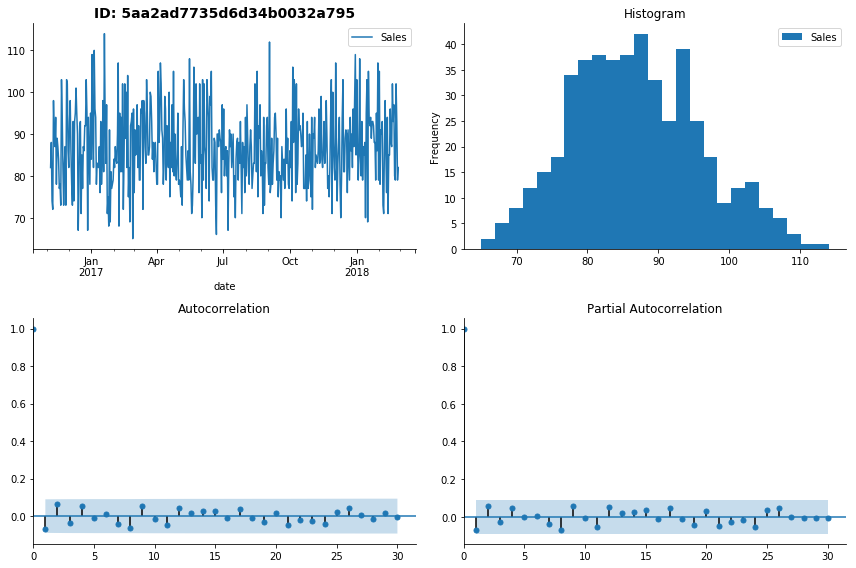

In [10]:
tsplot(prod1, 'ID: 5aa2ad7735d6d34b0032a795', lags=30)

In [11]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [12]:
prod1_transformed = prod1.copy()
prod1_transformed = np.log(prod1_transformed).diff(10).dropna()
#prod1_transformed = prod1_transformed.replace(-np.inf, 0).replace(np.inf, 0)
#prod1_transformed = prod1_transformed[prod1_transformed['Sales'] != 0]

In [13]:
prod1_transformed.shape

(469, 1)

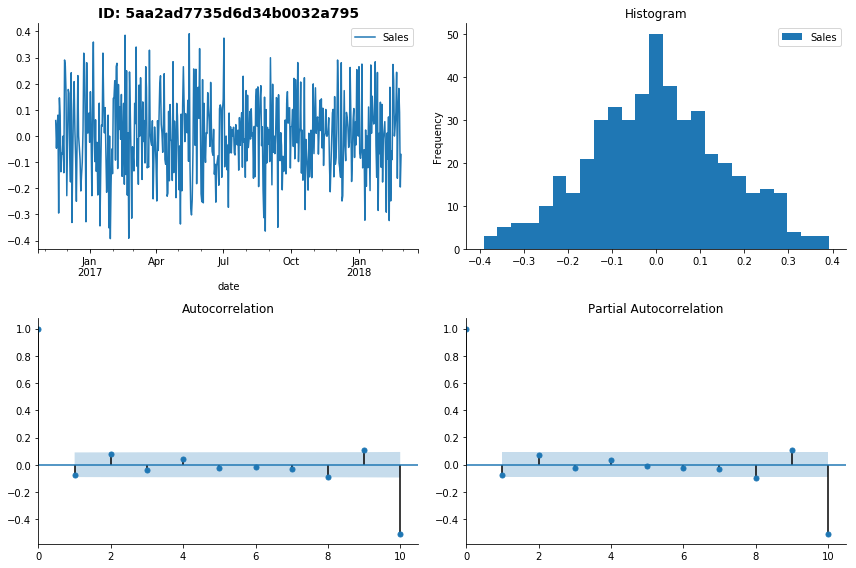

In [14]:
tsplot(prod1_transformed, 'ID: 5aa2ad7735d6d34b0032a795', lags=10)
plt.show()

In [15]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [16]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1_transformedTest = routines.tsTest(prod1_transformed['Sales'], '5aa2ad7735d6d34b0032a795')
prod1_transformedTest.adfuller()

5aa2ad7735d6d34b0032a795


,Value,Label
0,-8.667700e+00,Test Statistic
1,2.069387e-12,p-value
2,1.100000e+01,#Lags Used
3,4.570000e+02,Number of Observations Used
4,-3.978717e+00,Critical value for 1%
5,-3.420141e+00,Critical value for 5%
6,-3.132727e+00,Critical value for 10%


In [17]:
# Train-Test Set Split
train = ceil(prod1_transformed.shape[0] * 0.8)
y_train = prod1_transformed[0:train]
y_test = prod1_transformed[train:]
y_train.shape, y_test.shape

((376, 1), (93, 1))

In [18]:
y_train.head()

,Sales
date,
2016-11-16,0.059189
2016-11-17,-0.046520
2016-11-18,0.039740
2016-11-19,0.080043
2016-11-20,-0.294508


In [19]:
AIC = detpq(y_train['Sales'], par=range(0,8))

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/statespace/representation.py:375: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return matrix[[slice(None)]*(matrix.ndim-1) + [0]]
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-package

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: C

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.p

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.p

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.p

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.p

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/

/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.p

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:171: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/lib/python3.7/site-packages/st

In [20]:
AIC.head()

,index,param,AIC
0,170,"(7, 0, 7)",-472.293296
1,128,"(5, 0, 7)",-457.600761
2,105,"(4, 0, 7)",-456.703041
3,149,"(6, 0, 7)",-455.969868
4,80,"(3, 0, 7)",-438.700313


In [21]:
# AIC or AICc
# https://github.com/statsmodels/statsmodels/issues/1217
# http://www.stat.berkeley.edu/%7Ebinyu/summer08/Hurvich.AICc91.pdf
# http://myweb.uiowa.edu/cavaaugh/ms_lec_3_ho.pdf

In [22]:
# ARIMA model
#prod1_transformed_model = ARIMA(y_train['Sales'].values, order=(5, 1, 1))
# chosen: (0, 0, 1) but KDE is not close to N(0,1), (0,1,1) is much better
prod1_transformed_model = sm.tsa.statespace.SARIMAX(y_train['Sales'].values, order=(7, 0, 7))
results1 = prod1_transformed_model.fit(disp=-1)

/usr/lib/python3.7/site-packages/statsmodels/base/model.py:508: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


In [23]:
results1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  376
Model:               SARIMAX(7, 0, 7)   Log Likelihood                 251.147
Date:                Tue, 04 Sep 2018   AIC                           -472.293
Time:                        15:45:08   BIC                           -413.349
Sample:                             0   HQIC                          -448.895
                                - 376                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4214      0.059      7.113      0.000       0.305       0.537
ar.L2          0.2397      0.059      4.031      0.000       0.123       0.356
ar.L3          0.5363      0.065      8.308      0.000       0.410       0.663
ar.L4         -0.5672      0.066     -8.590      0.000      -0.697      -0.438
ar.L5         -0.1558      0.061     -2.558      0.011      -0.275      -0.036
ar.L6         -0.0924      0.065     -1.417      0.156      -0.220       0.035
ar.L7          0.1969      0.058      3.371      0.001       0.082       0.311
ma.L1         -0.4341      0.522     -0.831      0.406      -1.457       0.589
ma.L2         -0.1785      0.386     -0.462      0.644      -0.935       0.578
ma.L3         -0.8471      0.309     -2.741      0.006      -1.453      -0.241
ma.L4          0.8738      0.326      2.680      0.007       0.235       1.513
ma.L5          0.1628      0.271      0.601      0.548      -0.368       0.694
ma.L6          0.4466      0.793      0.563      0.573      -1.108       2.001
ma.L7         -0.9517      0.645     -1.475      0.140      -2.216       0.313
sigma2         0.0147      0.010      1.489      0.137      -0.005       0.034
===================================================================================
Ljung-Box (Q):                       67.62   Jarque-Bera (JB):                 4.65
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               0.61   Skew:                             0.24
Prob(H) (two-sided):                  0.01   Kurtosis:                         2.76
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

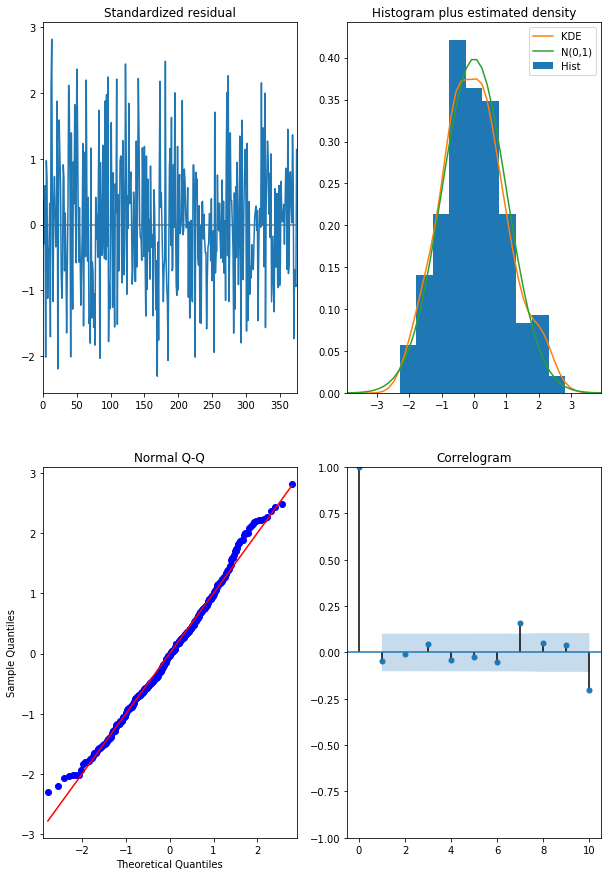

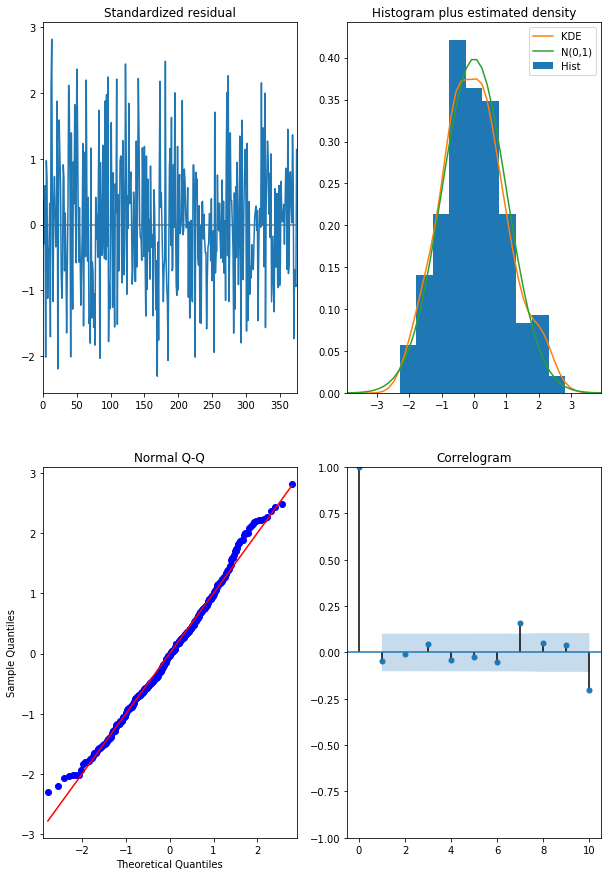

In [26]:
results1.plot_diagnostics(figsize=(10, 15))

In [27]:
plt.clf()

<Figure size 432x288 with 0 Axes>

In [28]:
y_test.shape

(93, 1)

In [29]:
y_pred = results1.get_prediction(start=train+1, end=prod1_transformed.shape[0], dynamic=False)
y_forecasted = y_pred.predicted_mean
y_forecasted.shape

(93,)

In [30]:
np.sqrt(mean_squared_error(y_pred=y_forecasted, y_true=y_test))

0.15505154734685814

In [31]:
mean_absolute_error(y_pred=y_forecasted, y_true=y_test)

0.12572628745770553

## <font color=blue> 2. Mongodb ID: 5aa39533ae1f941be7165ecd </font>

In [34]:
prod2 = genData('5aa39533ae1f941be7165ecd', conn, c, impute=True, freq='daily', standardize=False)

In [35]:
prod2.shape

(925, 1)

In [36]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2Test = routines.tsTest(prod2['Sales'], '5aa39533ae1f941be7165ecd')
prod2Test.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-1.282364e+01,Test Statistic
1,2.313895e-20,p-value
2,3.000000e+00,#Lags Used
3,9.210000e+02,Number of Observations Used
4,-3.968633e+00,Critical value for 1%
5,-3.415268e+00,Critical value for 5%
6,-3.129862e+00,Critical value for 10%


In [37]:
tsplot(prod2, 'ID: 5aa39533ae1f941be7165ecd', lags=40)

(<matplotlib.axes._subplots.AxesSubplot at 0x7f70d73b2e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f70d7840a20>)

<Figure size 432x288 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

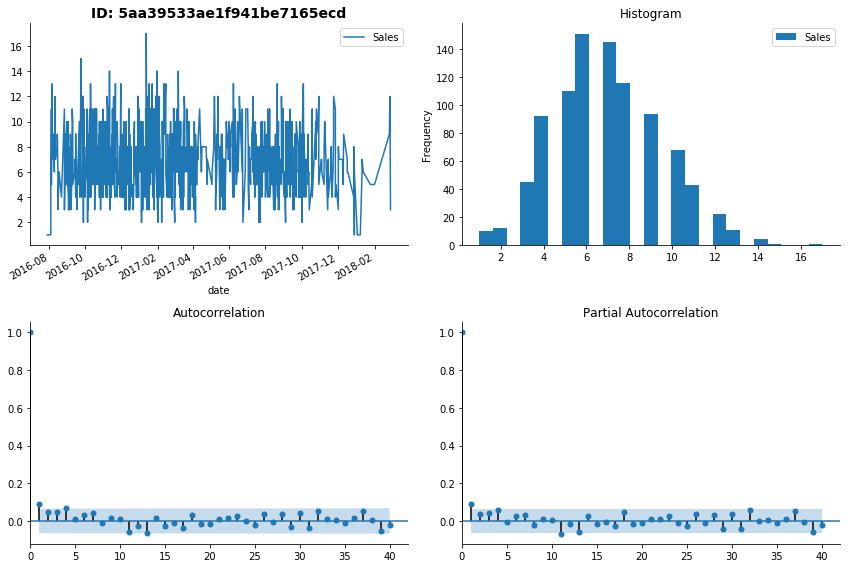

In [38]:
plt.show()

In [39]:
plt.clf()

In [40]:
prod2_transformed = prod2.copy()
prod2_transformed = np.log(prod2_transformed).diff(10).dropna()
prod2_transformed = prod2_transformed.replace(-np.inf, 0).replace(np.inf, 0)
prod2_transformed = prod2_transformed[prod2_transformed['Sales'] != 0]

In [41]:
prod2_transformed.shape

(811, 1)

<Figure size 432x288 with 0 Axes>

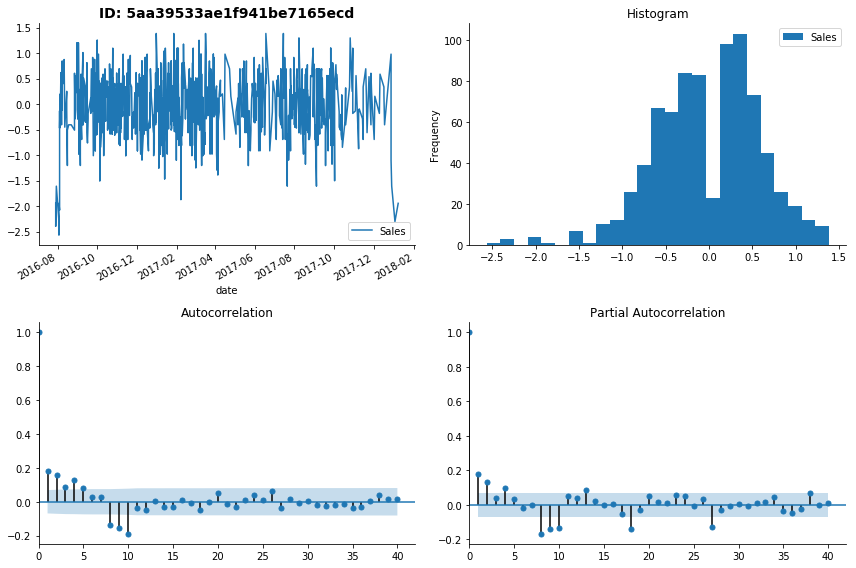

In [42]:
tsplot(prod2_transformed, 'ID: 5aa39533ae1f941be7165ecd', lags=40)
plt.show()

In [43]:
plt.clf()

In [44]:
# Stationarity test (Augmented Dickey-Fuller test)
prod2_transformedTest = routines.tsTest(prod2_transformed['Sales'], '5aa39533ae1f941be7165ecd')
prod2_transformedTest.adfuller()

5aa39533ae1f941be7165ecd


,Value,Label
0,-7.452959e+00,Test Statistic
1,1.307385e-09,p-value
2,1.800000e+01,#Lags Used
3,7.920000e+02,Number of Observations Used
4,-3.970246e+00,Critical value for 1%
5,-3.416048e+00,Critical value for 5%
6,-3.130321e+00,Critical value for 10%


In [45]:
# Train-Test Set Split
train2 = ceil(prod2_transformed.shape[0] * 0.8)
y_train2 = prod2_transformed[0:train2]
y_test2 = prod2_transformed[train2:]
y_train2.shape, y_test2.shape

((649, 1), (162, 1))

In [46]:
AICc2 = detpq(y_train2['Sales'].values, par=range(0,6))

In [47]:
AICc2.head()

,index,param,AIC


In [48]:
# ARIMA model
prod2_transformed_model = sm.tsa.statespace.SARIMAX(y_train2['Sales'].values, order=(2, 0, 5))
results2 = prod2_transformed_model.fit(disp=-1)

In [49]:
results2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  649
Model:               SARIMAX(2, 0, 5)   Log Likelihood                -529.290
Date:                Sat, 07 Jul 2018   AIC                           1074.580
Time:                        23:27:58   BIC                           1110.384
Sample:                             0   HQIC                          1088.468
                                - 649                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0376      0.191     -0.197      0.844      -0.411       0.336
ar.L2          0.7478      0.152      4.908      0.000       0.449       1.046
ma.L1          0.0545      0.204      0.267      0.790      -0.346       0.455
ma.L2         -0.7744      0.151     -5.115      0.000      -1.071      -0.478
ma.L3         -0.1651      0.050     -3.292      0.001      -0.263      -0.067
ma.L4         -0.1328      0.048     -2.751      0.006      -0.227      -0.038
ma.L5          0.0196      0.051      0.385      0.700      -0.080       0.119
sigma2         0.2975      0.021     13.848      0.000       0.255       0.340
===================================================================================
Ljung-Box (Q):                       81.18   Jarque-Bera (JB):                 4.68
Prob(Q):                              0.00   Prob(JB):                         0.10
Heteroskedasticity (H):               0.77   Skew:                            -0.16
Prob(H) (two-sided):                  0.06   Kurtosis:                         2.74
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

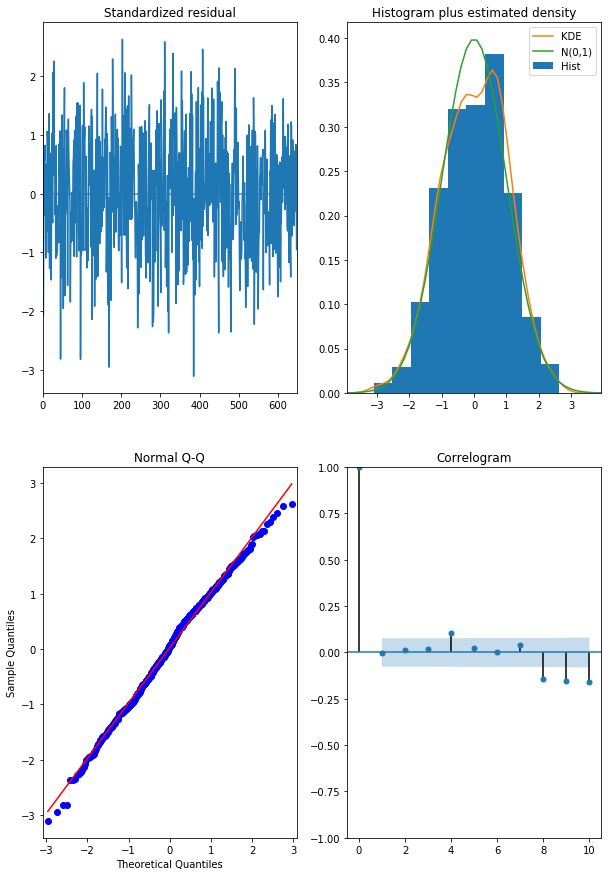

In [50]:
results2.plot_diagnostics(figsize=(10, 15))

In [51]:
plt.clf()

In [52]:
y_test2.shape

(162, 1)

In [53]:
y_pred2 = results2.get_prediction(start=train2+1, end=prod2_transformed.shape[0])
y_forecasted2 = y_pred2.predicted_mean
y_forecasted2.shape

(162,)

In [54]:
np.sqrt(mean_squared_error(y_pred=y_forecasted2, y_true=y_test2))

0.7324061509980692

## <font color=blue> 3. Mongodb ID: 5a93e8768cbad97881597597 </font>

In [161]:
prod3 = genData('5a93e8768cbad97881597597', conn, c, impute=True, freq='daily', actualrevcount=20, standardize=False)

In [162]:
prod3.shape

(1119, 1)

In [163]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3Test = routines.tsTest(prod3['Sales'], '5a93e8768cbad97881597597')
prod3Test.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-2.676379,Test Statistic
1,0.246021,p-value
2,21.000000,#Lags Used
3,1097.000000,Number of Observations Used
4,-3.967046,Critical value for 1%
5,-3.414500,Critical value for 5%
6,-3.129410,Critical value for 10%


In [167]:
tsplot(prod3, 'ID: 5a93e8768cbad97881597597', lags=30)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ffa0824a518>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa0867b710>)

<Figure size 432x288 with 0 Axes>

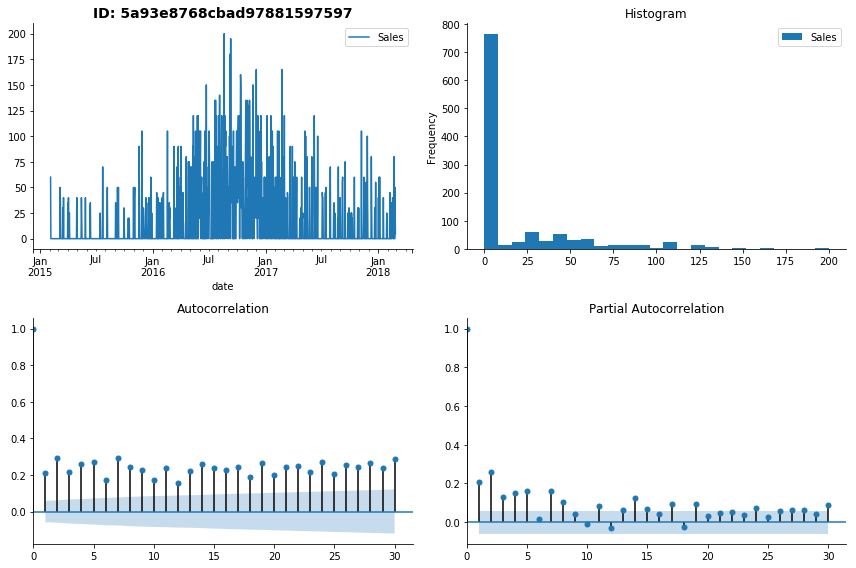

In [168]:
plt.show()

In [169]:
plt.clf()

In [170]:
prod3_transformed = prod3.copy()
prod3_transformed = np.log(prod3_transformed).diff(30).dropna()
prod3_transformed = prod3_transformed.replace(-np.inf, 0).replace(np.inf, 0)
prod3_transformed = prod3_transformed[prod3_transformed['Sales'] != 0]

In [171]:
prod3_transformed.shape

(147, 1)

<Figure size 432x288 with 0 Axes>

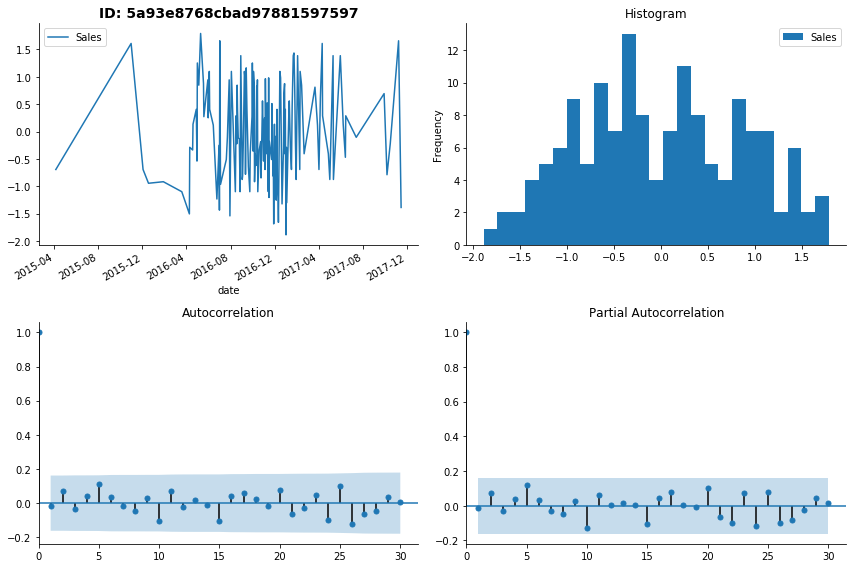

In [172]:
tsplot(prod3_transformed, 'ID: 5a93e8768cbad97881597597', lags=30)
plt.show()

In [173]:
plt.clf()

In [174]:
# Stationarity test (Augmented Dickey-Fuller test)
prod3_transformedTest = routines.tsTest(prod3_transformed['Sales'], '5a93e8768cbad97881597597')
prod3_transformedTest.adfuller()

5a93e8768cbad97881597597


,Value,Label
0,-1.206795e+01,Test Statistic
1,2.988304e-19,p-value
2,0.000000e+00,#Lags Used
3,1.460000e+02,Number of Observations Used
4,-4.022154e+00,Critical value for 1%
5,-3.441000e+00,Critical value for 5%
6,-3.144951e+00,Critical value for 10%


In [175]:
# Train-Test Set Split
train3 = ceil(prod3_transformed.shape[0] * 0.8)
y_train3 = prod3_transformed[0:train3]
y_test3 = prod3_transformed[train3:]
y_train3.shape, y_test3.shape

((118, 1), (29, 1))

In [206]:
AICc3 = detpq(y_train3['Sales'].values, par=range(0,6))

In [207]:
AICc3.head()

,index,param,AICc
0,37,"(2, 0, 2)",300.490726
1,0,"(0, 0, 0)",300.495264
2,58,"(3, 0, 2)",302.374663
3,17,"(1, 0, 0)",302.390914
4,38,"(2, 0, 3)",302.417705


In [199]:
# ARIMA model
prod3_transformed_model = sm.tsa.statespace.SARIMAX(y_train3['Sales'].values, order=(2, 0, 2))
results3 = prod3_transformed_model.fit(disp=-1)

In [200]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  118
Model:               SARIMAX(2, 0, 2)   Log Likelihood                -144.978
Date:                Sun, 01 Jul 2018   AIC                            299.955
Time:                        11:02:45   BIC                            313.808
Sample:                             0   HQIC                           305.580
                                - 118                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3342      0.077     -4.344      0.000      -0.485      -0.183
ar.L2         -0.8133      0.080    -10.217      0.000      -0.969      -0.657
ma.L1          0.4353      2.396      0.182      0.856      -4.260       5.131
ma.L2          0.9998     11.003      0.091      0.928     -20.566      22.566
sigma2         0.6603      7.252      0.091      0.927     -13.552      14.873
===================================================================================
Ljung-Box (Q):                       25.59   Jarque-Bera (JB):                 2.83
Prob(Q):                              0.96   Prob(JB):                         0.24
Heteroskedasticity (H):               0.84   Skew:                            -0.02
Prob(H) (two-sided):                  0.59   Kurtosis:                         2.24
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

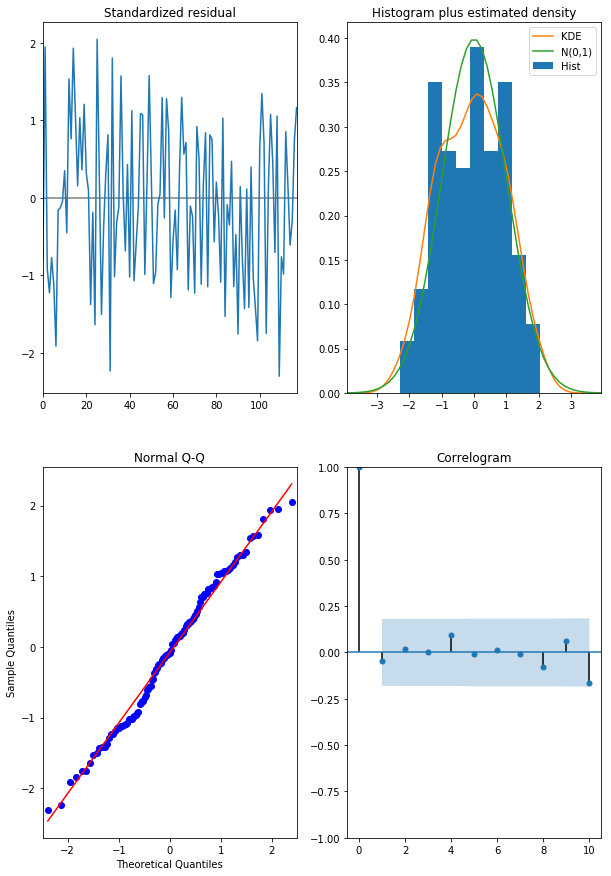

In [201]:
results3.plot_diagnostics(figsize=(10, 15))

In [202]:
plt.clf()

In [203]:
y_test3.shape

(29, 1)

In [204]:
y_pred3 = results3.get_prediction(start=train3+1, end=prod3_transformed.shape[0])
y_forecasted3 = y_pred3.predicted_mean
y_forecasted3.shape

(29,)

In [205]:
np.sqrt(mean_squared_error(y_pred=y_forecasted3, y_true=y_test3))

0.9235908419217068

## <font color=blue> 4. Mongodb ID: 5a95d7ae35d6d33d3fea56ff </font>

In [208]:
prod4 = genData('5a95d7ae35d6d33d3fea56ff', conn, c, impute=True, freq='daily', actualrevcount=20, standardize=False)

In [209]:
prod4.shape

(693, 1)

In [210]:
# Stationarity test (Augmented Dickey-Fuller test)
prod1Test = routines.tsTest(prod4['Sales'], '5a95d7ae35d6d33d3fea56ff')
prod1Test.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-5.206954,Test Statistic
1,0.000085,p-value
2,9.000000,#Lags Used
3,683.000000,Number of Observations Used
4,-3.972086,Critical value for 1%
5,-3.416938,Critical value for 5%
6,-3.130844,Critical value for 10%


In [214]:
tsplot(prod4, 'ID: 5a95d7ae35d6d33d3fea56ff', lags=30)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ffa0880a390>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa03bdf160>)

<Figure size 432x288 with 0 Axes>

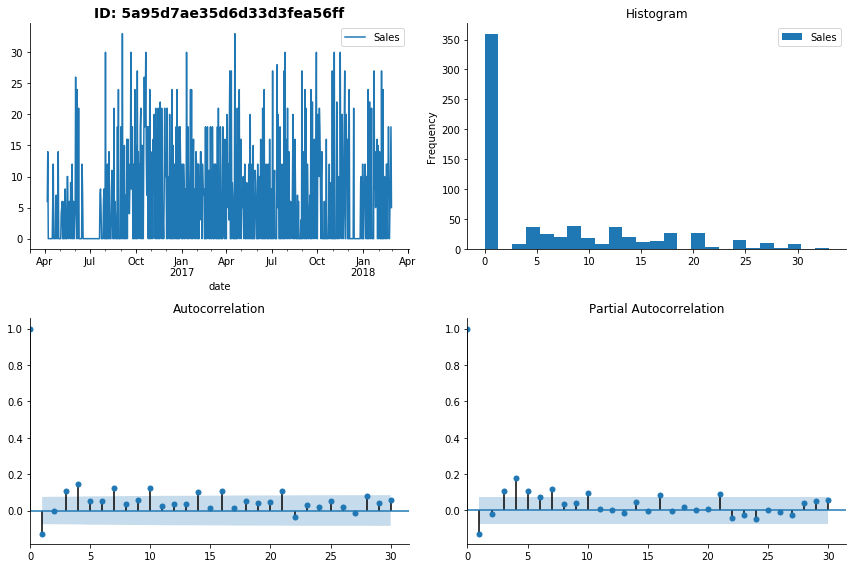

In [215]:
plt.show()

In [216]:
plt.clf()

In [217]:
prod4_transformed = prod4.copy()
prod4_transformed = np.log(prod4_transformed).diff(30).dropna()
prod4_transformed = prod4_transformed.replace(-np.inf, 0).replace(np.inf, 0)
prod4_transformed = prod4_transformed[prod4_transformed['Sales'] != 0]

In [218]:
prod4_transformed.shape

(149, 1)

<Figure size 432x288 with 0 Axes>

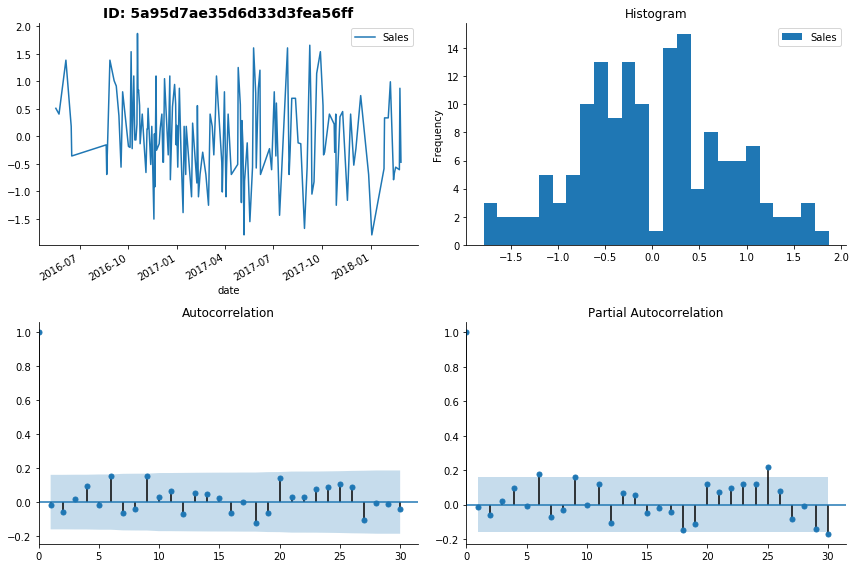

In [219]:
tsplot(prod4_transformed, 'ID: 5a95d7ae35d6d33d3fea56ff', lags=30)
plt.show()

In [220]:
plt.clf()

In [221]:
# Stationarity test (Augmented Dickey-Fuller test)
prod4_transformedTest = routines.tsTest(prod4_transformed['Sales'], '5a95d7ae35d6d33d3fea56ff')
prod4_transformedTest.adfuller()

5a95d7ae35d6d33d3fea56ff


,Value,Label
0,-1.256438e+01,Test Statistic
1,5.294804e-20,p-value
2,0.000000e+00,#Lags Used
3,1.480000e+02,Number of Observations Used
4,-4.021279e+00,Critical value for 1%
5,-3.440581e+00,Critical value for 5%
6,-3.144706e+00,Critical value for 10%


In [222]:
# Train-Test Set Split
train4 = ceil(prod4_transformed.shape[0] * 0.8)
y_train4 = prod4_transformed[0:train4]
y_test4 = prod4_transformed[train4:]
y_train4.shape, y_test4.shape

((120, 1), (29, 1))

In [223]:
AICc4 = detpq(y_train4['Sales'].values, par=range(0,6))

In [224]:
AICc4.head()

,index,param,AICc
0,21,"(1, 0, 4)",288.619422
1,0,"(0, 0, 0)",288.876971
2,5,"(0, 0, 5)",289.396380
3,37,"(2, 0, 3)",289.484967
4,44,"(2, 1, 4)",290.018304


In [232]:
# ARIMA model
prod4_transformed_model = sm.tsa.statespace.SARIMAX(y_train4['Sales'].values, order=(1, 1, 4))
results4 = prod4_transformed_model.fit(disp=-1)

In [233]:
results4.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                  120
Model:               SARIMAX(1, 1, 4)   Log Likelihood                -141.593
Date:                Sun, 01 Jul 2018   AIC                            295.185
Time:                        11:09:13   BIC                            311.860
Sample:                             0   HQIC                           301.956
                                - 120                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7526      0.218     -3.447      0.001      -1.180      -0.325
ma.L1         -0.2154      0.230     -0.935      0.350      -0.667       0.236
ma.L2         -0.8054      0.225     -3.584      0.000      -1.246      -0.365
ma.L3         -0.0996      0.112     -0.893      0.372      -0.318       0.119
ma.L4          0.2263      0.094      2.409      0.016       0.042       0.410
sigma2         0.6188      0.098      6.316      0.000       0.427       0.811
===================================================================================
Ljung-Box (Q):                       46.48   Jarque-Bera (JB):                 1.93
Prob(Q):                              0.22   Prob(JB):                         0.38
Heteroskedasticity (H):               1.57   Skew:                             0.16
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.47
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

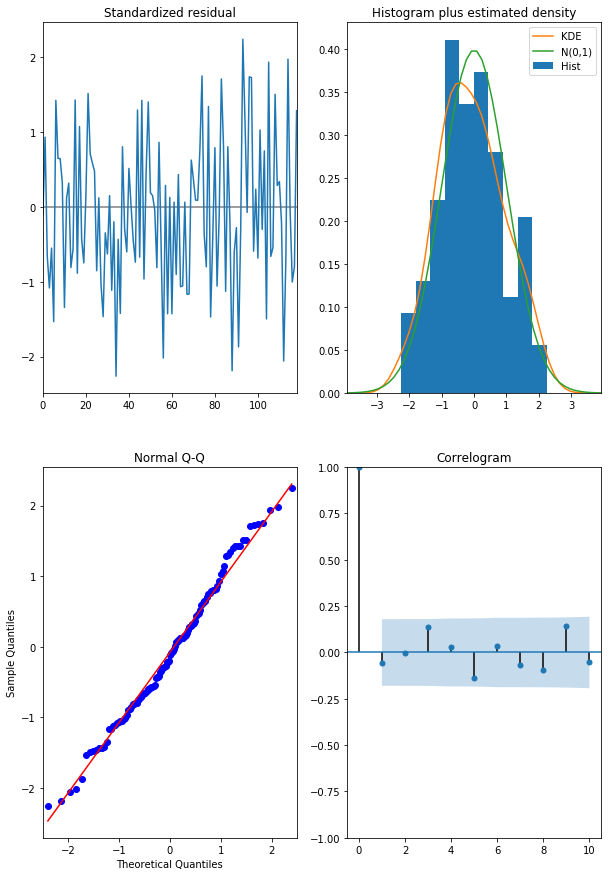

In [234]:
results4.plot_diagnostics(figsize=(10, 15))

In [235]:
plt.clf()

In [236]:
y_test4.shape

(29, 1)

In [237]:
y_pred4 = results4.get_prediction(start=train4+1, end=train4+y_test4.shape[0])
y_forecasted4 = y_pred4.predicted_mean
y_forecasted4.shape

(29,)

In [238]:
np.sqrt(mean_squared_error(y_pred=y_forecasted4, y_true=y_test4))

0.7451654804698068

## <font color=blue> 5. Mongodb ID: 5aa2c35e35d6d34b0032a796 </font>

In [354]:
prod5 = genData('5aa2c35e35d6d34b0032a796', conn, c, impute=True, freq='daily', actualrevcount=20, standardize=False)

In [355]:
prod5.shape

(428, 1)

In [356]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5Test = routines.tsTest(prod5['Sales'], '5aa2c35e35d6d34b0032a796')
prod5Test.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-5.872722,Test Statistic
1,0.000004,p-value
2,3.000000,#Lags Used
3,424.000000,Number of Observations Used
4,-3.980282,Critical value for 1%
5,-3.420896,Critical value for 5%
6,-3.133170,Critical value for 10%


In [357]:
tsplot(prod5, 'ID: 5aa2c35e35d6d34b0032a796', lags=20)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ffa02e93630>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa0288b6a0>)

<Figure size 432x288 with 0 Axes>

<Figure size 720x1080 with 0 Axes>

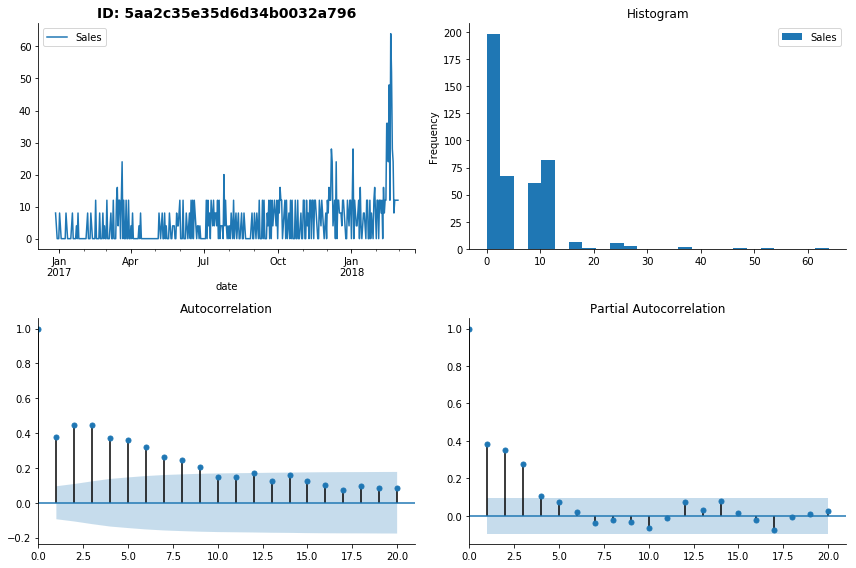

In [358]:
plt.show()

In [359]:
plt.clf()

In [360]:
prod5_transformed = prod5.copy()
prod5_transformed = np.log(prod5_transformed).diff(20).dropna()
prod5_transformed = prod5_transformed.replace(-np.inf, 0).replace(np.inf, 0)
prod5_transformed = prod5_transformed[prod5_transformed['Sales'] != 0]

In [361]:
prod5_transformed.shape

(86, 1)

<Figure size 432x288 with 0 Axes>

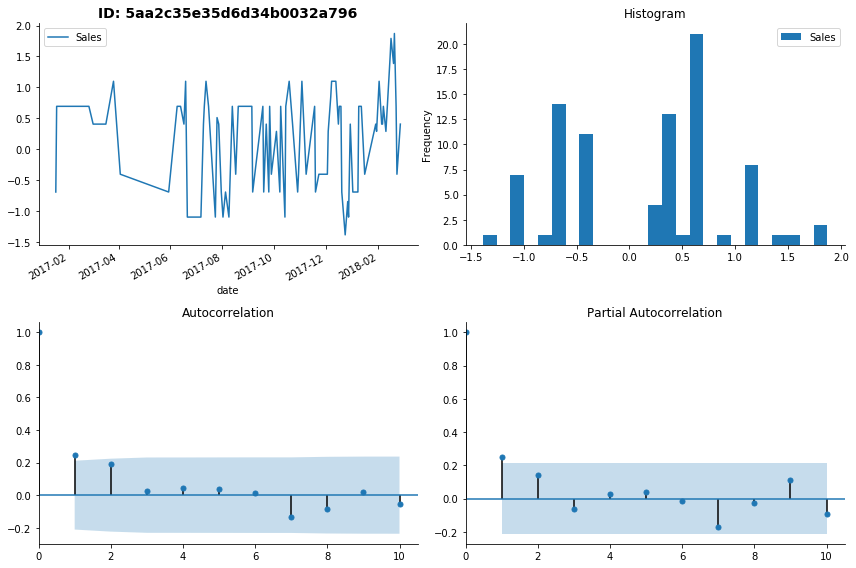

In [362]:
tsplot(prod5_transformed, 'ID: 5aa2c35e35d6d34b0032a796', lags=10)
plt.show()

In [363]:
plt.clf()

In [364]:
# Stationarity test (Augmented Dickey-Fuller test)
prod5_transformedTest = routines.tsTest(prod5_transformed['Sales'], '5aa2c35e35d6d34b0032a796')
prod5_transformedTest.adfuller()

5aa2c35e35d6d34b0032a796


,Value,Label
0,-7.143646e+00,Test Statistic
1,6.670082e-09,p-value
2,0.000000e+00,#Lags Used
3,8.500000e+01,Number of Observations Used
4,-4.069430e+00,Critical value for 1%
5,-3.463466e+00,Critical value for 5%
6,-3.158049e+00,Critical value for 10%


In [365]:
# Train-Test Set Split
train5 = ceil(prod5_transformed.shape[0] * 0.8)
y_train5 = prod5_transformed[0:train5]
y_test5 = prod5_transformed[train5:]
y_train5.shape, y_test5.shape

((69, 1), (17, 1))

In [366]:
AICc5 = detpq(y_train5['Sales'].values, par=range(0,6))

In [367]:
AICc5.head()

,index,param,AICc
0,0,"(0, 0, 0)",157.677394
1,18,"(1, 0, 0)",158.675067
2,1,"(0, 0, 1)",158.891950
3,2,"(0, 0, 2)",159.593644
4,39,"(2, 0, 0)",160.164536


In [383]:
# ARIMA model
prod5_transformed_model = sm.tsa.statespace.SARIMAX(y_train5['Sales'].values, order=(1, 1, 0))
results5 = prod5_transformed_model.fit(disp=-1)

In [384]:
results5.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   69
Model:               SARIMAX(1, 1, 0)   Log Likelihood                 -86.346
Date:                Sun, 01 Jul 2018   AIC                            176.691
Time:                        12:51:21   BIC                            181.130
Sample:                             0   HQIC                           178.450
                                 - 69                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.4925      0.111     -4.441      0.000      -0.710      -0.275
sigma2         0.7391      0.153      4.817      0.000       0.438       1.040
===================================================================================
Ljung-Box (Q):                       40.00   Jarque-Bera (JB):                 1.43
Prob(Q):                              0.47   Prob(JB):                         0.49
Heteroskedasticity (H):               0.55   Skew:                            -0.18
Prob(H) (two-sided):                  0.16   Kurtosis:                         2.38
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

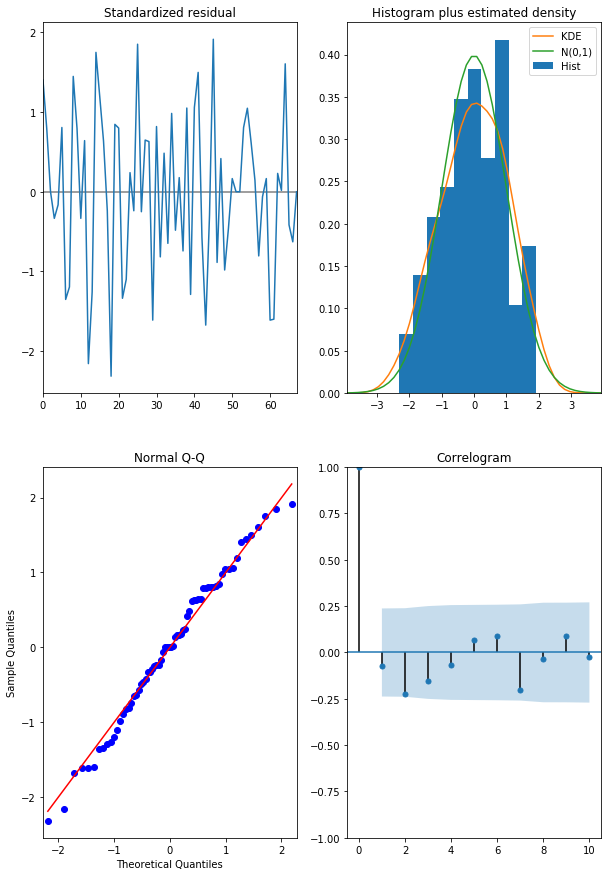

In [385]:
results5.plot_diagnostics(figsize=(10, 15))

In [386]:
plt.clf()

In [387]:
y_test5.shape

(17, 1)

In [388]:
y_pred5 = results5.get_prediction(start=train5+1, end=train5+y_test5.shape[0])
y_forecasted5 = y_pred5.predicted_mean
y_forecasted5.shape

(17,)

In [389]:
np.sqrt(mean_squared_error(y_pred=y_forecasted5, y_true=y_test5))

1.528563710524946

## <font color=blue> 6. Mongodb ID: 5a92474635d6d32207bcd343 </font>

In [415]:
prod6 = genData('5a92474635d6d32207bcd343', conn, c, impute=False, freq='daily', actualrevcount=20, standardize=False)

In [416]:
prod6.shape

(560, 1)

In [420]:
prod6 = prod6[prod6['Sales'] !=0]

In [421]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6Test = routines.tsTest(prod6['Sales'], '5a92474635d6d32207bcd343')
prod6Test.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-4.937326,Test Statistic
1,0.000267,p-value
2,0.000000,#Lags Used
3,32.000000,Number of Observations Used
4,-4.273535,Critical value for 1%
5,-3.557899,Critical value for 5%
6,-3.212366,Critical value for 10%


In [426]:
tsplot(prod6, 'ID: 5a92474635d6d32207bcd343', lags=10)

(<matplotlib.axes._subplots.AxesSubplot at 0x7ffa022720b8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7ffa021358d0>)

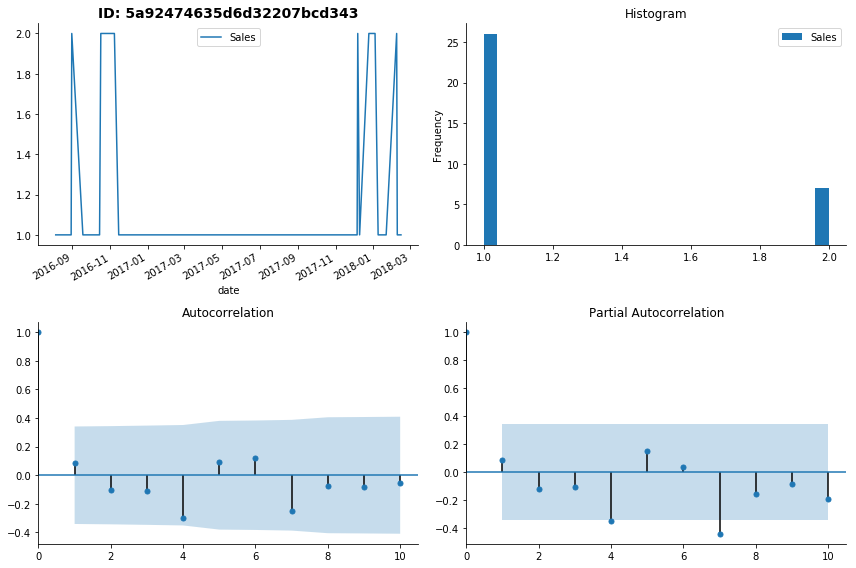

In [427]:
plt.show()

In [428]:
plt.clf()

In [431]:
prod6_transformed = prod6.copy()
#prod6_transformed = np.log(prod6_transformed).diff(30).dropna()
#prod6_transformed = prod6_transformed.replace(-np.inf, 0).replace(np.inf, 0)
#prod6_transformed = prod6_transformed[prod6_transformed['Sales'] != 0]

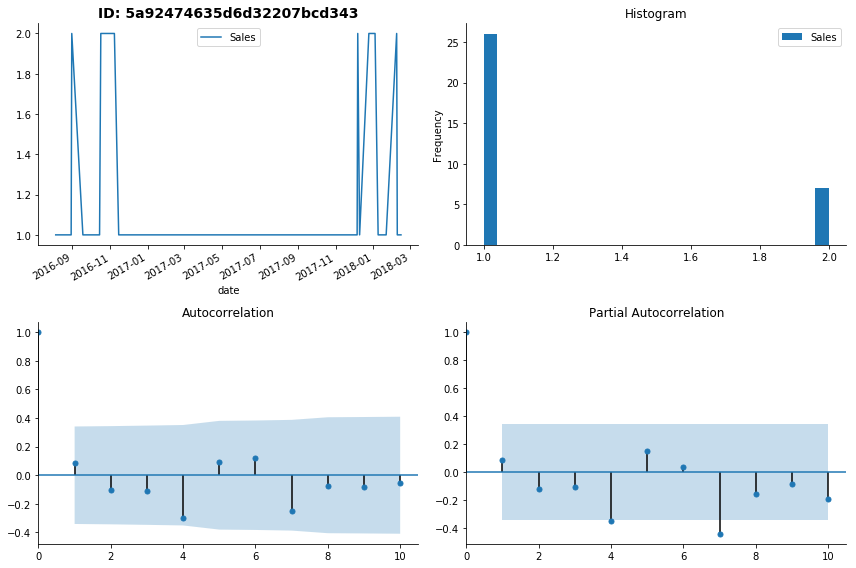

In [433]:
tsplot(prod6_transformed, 'ID: 5a92474635d6d32207bcd343', lags=10)
plt.show()

In [434]:
plt.clf()

In [435]:
# Stationarity test (Augmented Dickey-Fuller test)
prod6_transformedTest = routines.tsTest(prod6_transformed['Sales'], '5a92474635d6d32207bcd343')
prod6_transformedTest.adfuller()

5a92474635d6d32207bcd343


,Value,Label
0,-4.937326,Test Statistic
1,0.000267,p-value
2,0.000000,#Lags Used
3,32.000000,Number of Observations Used
4,-4.273535,Critical value for 1%
5,-3.557899,Critical value for 5%
6,-3.212366,Critical value for 10%


In [436]:
# Train-Test Set Split
train6 = ceil(prod6_transformed.shape[0] * 0.8)
y_train6 = prod6_transformed[0:train6]
y_test6 = prod6_transformed[train6:]
y_train6.shape, y_test6.shape

((27, 1), (6, 1))

In [437]:
AICc6 = detpq(y_train6['Sales'].values, par=range(0,6))

In [438]:
AICc6.head()

,index,param,AICc
0,7,"(0, 1, 1)",36.921866
1,8,"(0, 1, 2)",38.597286
2,21,"(1, 1, 1)",38.698168
3,22,"(1, 1, 2)",40.245419
4,9,"(0, 1, 3)",41.232384


In [444]:
# ARIMA model
prod6_transformed_model = sm.tsa.statespace.SARIMAX(y_train6['Sales'].values, order=(0, 0, 1))
results6 = prod6_transformed_model.fit(disp=-1)

In [445]:
results6.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Statespace Model Results                           
==============================================================================
Dep. Variable:                      y   No. Observations:                   27
Model:               SARIMAX(0, 0, 1)   Log Likelihood                 -34.701
Date:                Sun, 01 Jul 2018   AIC                             73.403
Time:                        13:10:21   BIC                             75.994
Sample:                             0   HQIC                            74.173
                                 - 27                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.7822      0.168      4.665      0.000       0.454       1.111
sigma2         0.7390      0.215      3.442      0.001       0.318       1.160
===================================================================================
Ljung-Box (Q):                       52.34   Jarque-Bera (JB):                 3.61
Prob(Q):                              0.00   Prob(JB):                         0.16
Heteroskedasticity (H):               1.41   Skew:                             0.77
Prob(H) (two-sided):                  0.62   Kurtosis:                         3.90
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

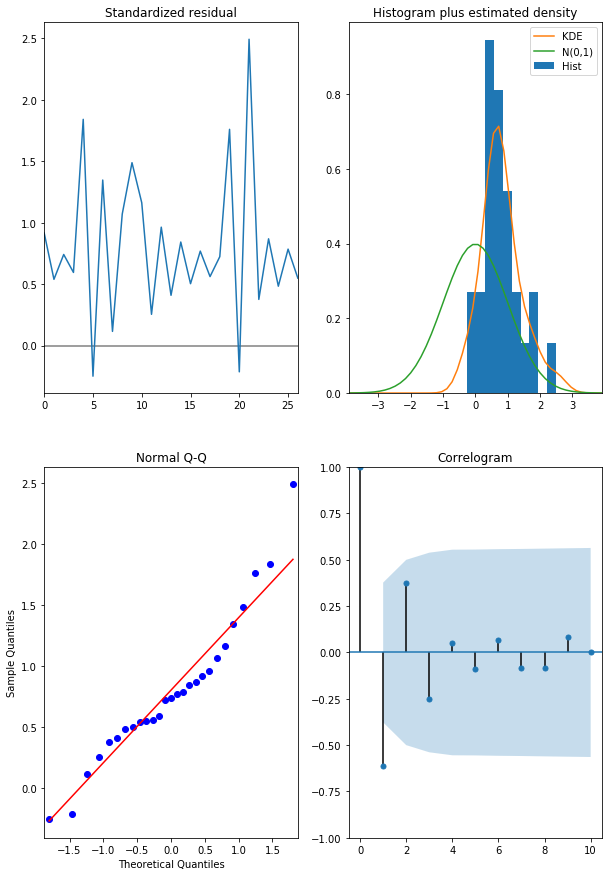

In [446]:
results6.plot_diagnostics(figsize=(10, 15))

In [447]:
plt.clf()

In [448]:
y_test6.shape

(6, 1)

In [449]:
y_pred6 = results6.get_prediction(start=train6+1, end=train6+y_test6.shape[0])
y_forecasted6 = y_pred6.predicted_mean
y_forecasted6.shape

(6,)

In [450]:
np.sqrt(mean_squared_error(y_pred=y_forecasted6, y_true=y_test6))

1.224744871391589